# Wildfire susceptibility

## Data preprocessing and dataset construction

## Spatial Cross Validation

## Libraries & Data Importation

In [71]:
# general usage ML libraries 
import math
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 25)

# vector operations
import geopandas as gpd
import shapely.geometry
import shapely.wkt

# raster operations
import os
from osgeo import gdal, osr
import rasterio.mask 
import rasterstats
import rasterio 
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.features import rasterize

import subprocess

# CRS transformations
import pyproj

# interpretability
import shap

# visualization
import seaborn as sn

In [72]:
DATA_PATH = 'data_final/'

# Land cover data
LC_YEAR = [1990, 2000, 2006, 2012, 2018]
LC_PATHS = [DATA_PATH+'lc/LC_'+str(year)+'_ND_REC.tif' for year in LC_YEAR]

# distance to urban areas
DISTANCE_PATHS = [DATA_PATH+'distance/URB_DIST_'+str(year)+'.tif' for year in LC_YEAR]

# most recent fires year on top
FIREYEAR = 'data_final/fires/FIREYEAR.tif'

# fire binary variable per time period
FIRE_YEAR = ['2001-2005', '2012-2017', '2018', '2019', '2020', '2021', '2022']
YEAR_PATHS = ['FIRE_ANTE_2006.tif', 'FIRE_2012_TO_2018.tif', 'FIRE_2018.tif', 'FIRE_2019.tif', 'FIRE_2020.tif', 
                  'FIRE_2021.tif', 'FIRE_2022.tif']

FIREYEAR_PATHS = ['data_final/fires/'+year_path for year_path in YEAR_PATHS]

# topographic data
DEM_PATH = 'data_final/topographic/dem.tif'
SLOPE_PATH = 'data_final/topographic/SLOPE_ND.tif'
ASPECT_PATH = 'data_final/topographic/aspect.tif'
HILLSHADE_PATH = 'data_final/topographic/hillshade.tif'

# protected areas
PROTECTED_PATH = 'data_final/protected/raster_natural_protected.tif'

# vegetation seasonal data
VEGETATION_YEAR = ['2017', '2018', '2019', '2020', '2021']
VEGETATION_SEASON = ['season1', 'season2']
VEGETATION_VARS = ['QFLAG', 'MINV', 'MAXV', 'AMPL', 'RSLOPE', 'LSLOPE']
VEGETATION_PATHS = ['data_final/season/'+year+'/merged_'+year+'_'+season+'_'+var+'.tif' for year in VEGETATION_YEAR for var in VEGETATION_VARS
                   for season in VEGETATION_SEASON]

VEG_IND_VARS = ['ndvi', 'vi', 'evi']
VEG_IND_YEAR = VEGETATION_YEAR[1:] + ['2022']


# population density
DENSITY_PATH = 'data_final/population/population_density_mode.tif'

# distance to populated areas
DENSITY_VALUES = ['2', '3', '4']

# emissivity and land surface temperature
TEMP_YEAR = ['2018', '2019', '2020', '2021', '2022']
EMISSIVITY_PATHS = ['data_final/emissivity/emissivity_'+year+'.tif' for year in TEMP_YEAR]
LST_PATHS = ['data_final/emissivity/lst_'+year+'.tif' for year in TEMP_YEAR]

In [73]:
dist_density_raster = {}
dist_density_array = {}

[dist_density_raster.update({value: rasterio.open('data_final/population/distance_density_'+value+'.tif')}) for value in DENSITY_VALUES]
[dist_density_array.update({value: dist_density_raster[value].read(1).flatten()}) for value in DENSITY_VALUES]

# vegetation (Nasa)

veg_ind_raster = {}
veg_ind_array = {}

[veg_ind_raster.update({var+'_'+year : rasterio.open('data_final/vegetation/'+var+'_'+year+'.tif')}) for year in VEG_IND_YEAR 
 for var in VEG_IND_VARS]
[veg_ind_array.update({var+'_'+year: veg_ind_raster[var+'_'+year].read(1).flatten()}) for year in VEG_IND_YEAR for var in VEG_IND_VARS]

# vegetation (wekeo)
vegetation_raster = {}
vegetation_array = {}

[vegetation_raster.update({var+'_'+year+'_'+season : rasterio.open('data_final/season/'+year+'/merged_'+year+'_'+season+'_'+var+'.tif') }) 
 for (i, year) in enumerate(VEGETATION_YEAR) for (y, var) in enumerate(VEGETATION_VARS) for (u, season) in enumerate(VEGETATION_SEASON)]
[vegetation_raster.update({var+'_2022_season1': vegetation_raster[var+'_2021_season1']}) for var in VEGETATION_VARS]

[vegetation_array.update({var+'_'+year+'_'+season : vegetation_raster[var+'_'+year+'_'+season].read(1).flatten() }) for (i, year) in enumerate(VEGETATION_YEAR) 
 for (y, var) in enumerate(VEGETATION_VARS) for (u, season) in enumerate(VEGETATION_SEASON)]
[vegetation_array.update({var+'_2022_season1': vegetation_array[var+'_2021_season1']}) for var in VEGETATION_VARS]


# emissivity and land surface temperature rasters
emissivity_raster = {}
emissivity_array = {}

[emissivity_raster.update({str(year) : rasterio.open(EMISSIVITY_PATHS[i]) }) for (i, year) in enumerate(TEMP_YEAR)]
[emissivity_array.update({str(year) : emissivity_raster[str(year)].read(1).flatten()}) for (i, year) in enumerate(TEMP_YEAR)]


lst_raster = {}
lst_array = {}

[lst_raster.update({str(year) : rasterio.open(LST_PATHS[i]) }) for (i, year) in enumerate(TEMP_YEAR)]
[lst_array.update({str(year) : lst_raster[str(year)].read(1).flatten()}) for (i, year) in enumerate(TEMP_YEAR)]

# land cover rasters
lc_rasters = {}
lc_array = {}

[lc_rasters.update({str(year) : rasterio.open(LC_PATHS[i]) }) for (i, year) in enumerate(LC_YEAR)]
[lc_array.update({str(year) : lc_rasters[str(year)].read(1).flatten().astype(np.int8) }) for (i, year) in enumerate(LC_YEAR)]

# distance to urban facilities
dist_rasters = {}
dist_array = {}

[dist_rasters.update({str(year) : rasterio.open(DISTANCE_PATHS[i]) }) for (i, year) in enumerate(LC_YEAR)]
[dist_array.update({str(year) : dist_rasters[str(year)].read(1).flatten() }) for (i, year) in enumerate(LC_YEAR)]


# fireyear raster
#fireyear_raster = rasterio.open(DATA_PATH+'FIREYEAR.tif')
fireyear_raster = {}
fireyear_array = {}
fireyear_array_bin = {}

[fireyear_raster.update({year : rasterio.open(FIREYEAR_PATHS[i]) }) for (i, year) in enumerate(FIRE_YEAR)]
[fireyear_array.update({year : fireyear_raster[str(year)].read(1).flatten() }) for (i, year) in enumerate(FIRE_YEAR)]
[fireyear_array_bin.update({year : np.array(fireyear_array[str(year)]) > 0 }) for (i, year) in enumerate(FIRE_YEAR)]

cumulated_fireyear_raster = rasterio.open(DATA_PATH+'fires/FIREYEAR.tif')
cumulated_fireyear_array = cumulated_fireyear_raster.read(1).flatten()

cumulated_fireyear_raster_train = rasterio.open(DATA_PATH + 'fires/FIREYEAR_TRAIN.tif')
cumulated_fireyear_array_train = cumulated_fireyear_raster_train.read(1).flatten()

# topographic variables
dem_raster = rasterio.open(DEM_PATH)
dem_array = dem_raster.read(1).flatten()

slope_raster = rasterio.open(SLOPE_PATH)
slope_array = slope_raster.read(1).flatten()

aspect_raster = rasterio.open(ASPECT_PATH)
aspect_array = aspect_raster.read(1).flatten()

hillshade_raster = rasterio.open(HILLSHADE_PATH)
hillshade_array = hillshade_raster.read(1).flatten()

# protected areas
protected_raster = rasterio.open(PROTECTED_PATH)
protected_array = protected_raster.read(1).flatten()

# population density
density_raster = rasterio.open(DENSITY_PATH)
density_array = density_raster.read(1).flatten()

## Datasets construction

### Training dataset

In [74]:
df_data = pd.DataFrame(data=np.c_[
                                  # land cover
                                  lc_array['1990'], lc_array['2000'], lc_array['2006'], 
                                  lc_array['2012'], lc_array['2018'],
                                  
                                  # topographic variables
                                  slope_array, dem_array, protected_array, 
                                  aspect_array, hillshade_array,
                                  
                                  # distance to artificial surfaces
                                  dist_array['1990'], 
                                  dist_array['2000'], 
                                  dist_array['2006'], 
                                  dist_array['2012'], 
                                  dist_array['2018'], 
                                  
                                  # fire binary per year
                                  fireyear_array_bin['2001-2005'], 
                                  fireyear_array_bin['2012-2017'], 
                                  fireyear_array_bin['2018'], 
                                  fireyear_array_bin['2019'], 
                                  fireyear_array_bin['2020'], 
                                  fireyear_array_bin['2021'],
                                  
                                  # cumulated fireyear
                                  cumulated_fireyear_array_train, 
                                  
                                  
                                  # vegetation data (Wekeo)
                                  vegetation_array['QFLAG_2017_season1'], vegetation_array['MINV_2017_season1'], 
                                  vegetation_array['MAXV_2017_season1'], vegetation_array['RSLOPE_2017_season1'], 
                                  vegetation_array['LSLOPE_2017_season1'], vegetation_array['AMPL_2017_season1'], 
                       
                                  vegetation_array['QFLAG_2018_season1'], vegetation_array['MINV_2018_season1'], 
                                  vegetation_array['MAXV_2018_season1'], vegetation_array['RSLOPE_2018_season1'], 
                                  vegetation_array['LSLOPE_2018_season1'], vegetation_array['AMPL_2018_season1'],
                                  
                                  
                                  vegetation_array['QFLAG_2019_season1'], vegetation_array['MINV_2019_season1'], 
                                  vegetation_array['MAXV_2019_season1'], vegetation_array['RSLOPE_2019_season1'], 
                                  vegetation_array['LSLOPE_2019_season1'], vegetation_array['AMPL_2019_season1'],
                                  
                                  vegetation_array['QFLAG_2020_season1'], vegetation_array['MINV_2020_season1'], 
                                  vegetation_array['MAXV_2020_season1'], vegetation_array['RSLOPE_2020_season1'], 
                                  vegetation_array['LSLOPE_2020_season1'], vegetation_array['AMPL_2020_season1'],
                                  
                                  vegetation_array['QFLAG_2021_season1'], vegetation_array['MINV_2021_season1'], 
                                  vegetation_array['MAXV_2021_season1'], vegetation_array['RSLOPE_2021_season1'], 
                                  vegetation_array['LSLOPE_2021_season1'], vegetation_array['AMPL_2021_season1'], 
                                  
                                  
                                  lst_array['2018'], lst_array['2019'], lst_array['2020'], lst_array['2021'],
                                  emissivity_array['2018'], emissivity_array['2019'], emissivity_array['2020'], 
                                  emissivity_array['2021'], veg_ind_array['ndvi_2018'], veg_ind_array['ndvi_2019'],
                                  veg_ind_array['ndvi_2020'], veg_ind_array['ndvi_2021'], 
                                  
                                  veg_ind_array['evi_2018'], veg_ind_array['evi_2019'],
                                  veg_ind_array['evi_2020'], veg_ind_array['evi_2021'],
                                  
                                  veg_ind_array['vi_2018'], veg_ind_array['vi_2019'],
                                  veg_ind_array['vi_2020'], veg_ind_array['vi_2021']
                                 ])


columns_df = [
              # land cover
              'LC90', 'LC00', 'LC06', 'LC12', 'LC18', 
              
              # topographic variables
              'slope', 'dem', 'protected', 'aspect', 'hillshade',
              
              # distance to artificial surfaces
              'URB90', 'URB00', 'URB06', 'URB12', 'URB18',
              
              # fire per year binary
              'F/2001-2005', 'F/2012-2017', 'F/2018', 'F/2019', 'F/2020', 'F/2021', 
              
              # cumulated fireyear
              'fire',  
              
              # vegetation data (wekeo)
              'QFLAG_2017_s1', 'MINV_2017_s1', 'MAXV_2017_s1', 'RSLOPE_2017_s1', 'LSLOPE_2017_s1','AMPL_2017_s1',
              'QFLAG_2018_s1', 'MINV_2018_s1', 'MAXV_2018_s1', 'RSLOPE_2018_s1', 'LSLOPE_2018_s1','AMPL_2018_s1',
              'QFLAG_2019_s1', 'MINV_2019_s1', 'MAXV_2019_s1', 'RSLOPE_2019_s1', 'LSLOPE_2019_s1','AMPL_2019_s1',
              'QFLAG_2020_s1', 'MINV_2020_s1', 'MAXV_2020_s1', 'RSLOPE_2020_s1', 'LSLOPE_2020_s1','AMPL_2020_s1',
               'QFLAG_2021_s1', 'MINV_2021_s1', 'MAXV_2021_s1', 'RSLOPE_2021_s1', 'LSLOPE_2021_s1','AMPL_2021_s1', 
              
              # land surface temperature
              'LST_2018', 'LST_2019', 'LST_2020', 'LST_2021', 
    
              # emissivity
              'EMI_2018', 'EMI_2019','EMI_2020', 'EMI_2021', 
    
              # extra vegetation data
              'NDVI_2018', 'NDVI_2019', 'NDVI_2020', 'NDVI_2021', 
              'EVI_2018', 'EVI_2019', 'EVI_2020', 'EVI_2021', 
              'VI_2018', 'VI_2019', 'VI_2020', 'VI_2021', 
            ]

df_data.columns = columns_df

In [75]:
# Function to select the Land cover corresponding to the fire year

def find_year_lc(fire_year, df, column):
    # Value of fire = 0 corresponds to no fire for the region
    if fire_year==0 : 
        return df[column+'18']
    elif fire_year<2000 :
        return df[column+'90']
    elif fire_year<2006 :
        return df[column+'00']
    elif fire_year<2012 : 
        return df[column+'06']
    elif fire_year<2018 :
        return df[column+'12']
    else : 
        return df[column+'18']
    
def find_year_vegetation(fire_year, df, column):
    # 
    if fire_year==0 : 
        return df[column+'_2021_s1']
    elif fire_year<=2017 :
        return df[column+'_2017_s1']
    elif fire_year==2018 :
        return df[column+'_2018_s1']
    elif fire_year==2019 :
        return df[column+'_2019_s1']
    elif fire_year==2020 : 
        return df[column+'_2020_s1']
    elif fire_year==2021 :
        return df[column+'_2021_s1']
    else : 
        return df[column+'_2021_s1']
    
def find_year_emi_ind(fire_year, df, column):
    if fire_year==0 : 
        return df[column+'_2021']
    elif fire_year<=2018 :
        return df[column+'_2018']
    elif fire_year==2019 :
        return df[column+'_2019']
    elif fire_year==2020 : 
        return df[column+'_2020']
    elif fire_year==2021 :
        return df[column+'_2021']
    else : 
        return df[column+'_2021']

In [76]:
%%time
# Selecting the Land cover and distance to artifical surfaces corresponding to the fire year
df_data['lc'] = df_data.apply(lambda x: find_year_lc(x['fire'], x, 'LC'), axis = 1)
df_data['urb'] = df_data.apply(lambda x: find_year_lc(x['fire'], x, 'URB'), axis = 1)

drop_columns = ['LC90', 'LC00', 'LC06', 'LC12', 'LC18', 'URB90', 'URB00', 'URB06', 'URB12', 'URB18']

df_data = df_data.drop(columns=drop_columns)

CPU times: user 1min 36s, sys: 2.12 s, total: 1min 38s
Wall time: 1min 47s


In [77]:
%%time
# Selecting vegetation indices variables corresponding to the fire year
df_data['qflag'] = df_data.apply(lambda x: find_year_vegetation(x['fire'], x, 'QFLAG'), axis = 1)
df_data['ampl'] = df_data.apply(lambda x: find_year_vegetation(x['fire'], x, 'AMPL'), axis = 1)
df_data['minv'] = df_data.apply(lambda x: find_year_vegetation(x['fire'], x, 'MINV'), axis = 1)
df_data['maxv'] = df_data.apply(lambda x: find_year_vegetation(x['fire'], x, 'MAXV'), axis = 1)
df_data['rslope'] = df_data.apply(lambda x: find_year_vegetation(x['fire'], x, 'RSLOPE'), axis = 1)
df_data['lslope'] = df_data.apply(lambda x: find_year_vegetation(x['fire'], x, 'LSLOPE'), axis = 1)

drop_columns = ['QFLAG_2017_s1', 'MINV_2017_s1', 'MAXV_2017_s1', 'RSLOPE_2017_s1', 'LSLOPE_2017_s1',
                  'AMPL_2017_s1',
                   'QFLAG_2018_s1', 'MINV_2018_s1', 'MAXV_2018_s1', 'RSLOPE_2018_s1', 'LSLOPE_2018_s1',
                  'AMPL_2018_s1',
                   'QFLAG_2019_s1', 'MINV_2019_s1', 'MAXV_2019_s1', 'RSLOPE_2019_s1', 'LSLOPE_2019_s1',
                  'AMPL_2019_s1',
                   'QFLAG_2020_s1', 'MINV_2020_s1', 'MAXV_2020_s1', 'RSLOPE_2020_s1', 'LSLOPE_2020_s1',
                  'AMPL_2020_s1',
                   'QFLAG_2021_s1', 'MINV_2021_s1', 'MAXV_2021_s1', 'RSLOPE_2021_s1', 'LSLOPE_2021_s1',
                  'AMPL_2021_s1']

df_data = df_data.drop(columns=drop_columns)

CPU times: user 4min 42s, sys: 10 s, total: 4min 52s
Wall time: 5min 18s


In [78]:
df_data['dist_2'] = dist_density_array['2']
df_data['dist_3'] = dist_density_array['3']
df_data['dist_4'] = dist_density_array['4']

In [79]:
%%time
df_data['emi'] = df_data.apply(lambda x: find_year_emi_ind(x['fire'], x, 'EMI'), axis = 1)
df_data['lst'] = df_data.apply(lambda x: find_year_emi_ind(x['fire'], x, 'LST'), axis = 1)

drop_columns = ['LST_2018', 'LST_2019', 'LST_2020', 'LST_2021', 'EMI_2018', 'EMI_2019',
              'EMI_2020', 'EMI_2021']

df_data = df_data.drop(columns=drop_columns)

CPU times: user 1min 32s, sys: 2.97 s, total: 1min 35s
Wall time: 1min 43s


In [80]:
%%time
df_data['ndvi'] = df_data.apply(lambda x: find_year_emi_ind(x['fire'], x, 'NDVI'), axis = 1)
df_data['evi'] = df_data.apply(lambda x: find_year_emi_ind(x['fire'], x, 'EVI'), axis = 1)
df_data['vi'] = df_data.apply(lambda x: find_year_emi_ind(x['fire'], x, 'VI'), axis = 1)

drop_columns = ['NDVI_2018', 'NDVI_2019', 'NDVI_2020', 'NDVI_2021', 
              'EVI_2018', 'EVI_2019', 'EVI_2020', 'EVI_2021', 
              'VI_2018', 'VI_2019', 'VI_2020', 'VI_2021']

df_data = df_data.drop(columns=drop_columns)

CPU times: user 2min 18s, sys: 4.56 s, total: 2min 23s
Wall time: 2min 34s


In [81]:
# year of the data of a cell
df_data['year'] = df_data.apply(lambda x : 2018 if(x['fire'] == 0) else x['fire'], axis=1)

In [82]:
# binary variable indicating if cell has burnt
df_data['is_fire'] = df_data.apply(lambda x : 1 if(x['fire'] != 0) else 0 , axis=1)

In [83]:
%%time
threshold_years = [2005, 2012, 2018, 2019, 2020, 2021]
drop_columns = ['F/2001-2005', 'F/2012-2017', 'F/2018', 'F/2019', 'F/2020', 'F/2021']

def fire_count_year(x):
    count = 0
    year = x['year']
    for col, threshold in zip(drop_columns, threshold_years):
        if (year > threshold):
            count += x[col]
    return count
    
df_data['fire_count'] = df_data.apply(lambda x: fire_count_year(x), axis = 1)

df = df_data.drop(columns=drop_columns)

CPU times: user 55.6 s, sys: 1.26 s, total: 56.8 s
Wall time: 1min 3s


In [84]:
lc_cols = list(pd.get_dummies(df.lc, prefix='lc').columns)

name_list = ['Empty', 'Artificial surfaces', 'Wetlands', 'Non-irrigated arable land',
            'Vineyards', 'Fruit trees and berry plantations', 'Pastures',
            'Complex cultivation patterns', 'Land principally occupied by agriculture with significant areas of natural vegetation', 
            'Broad-leaved forest', 'Coniferous forest', 'Mixed forest', 'Natural grasslands', 
            'Moors and heathland', 'Transitional woodland-shrub', 'Beaches - dunes - sands', 
            'Bare rocks', 'Sparsely vegetated areas', 'Glaciers and perpetual snow']

# mapping from column name i.e LC_[grid_code_value] => land cover type
legend_column = dict(list(zip(lc_cols, name_list)))
print(legend_column)

# mapping from land cover type => column name i.e LC_[grid_code_value]
legend_name = dict(list(zip(name_list, lc_cols)))

# we keep the grid value of the land cover for usability reasons
df[lc_cols] = pd.get_dummies(df.lc, prefix='lc')

# example usage
len(df[df[legend_name['Artificial surfaces']] == 1])

{'lc_0.0': 'Empty', 'lc_1.0': 'Artificial surfaces', 'lc_2.0': 'Wetlands', 'lc_12.0': 'Non-irrigated arable land', 'lc_15.0': 'Vineyards', 'lc_16.0': 'Fruit trees and berry plantations', 'lc_18.0': 'Pastures', 'lc_20.0': 'Complex cultivation patterns', 'lc_21.0': 'Land principally occupied by agriculture with significant areas of natural vegetation', 'lc_23.0': 'Broad-leaved forest', 'lc_24.0': 'Coniferous forest', 'lc_25.0': 'Mixed forest', 'lc_26.0': 'Natural grasslands', 'lc_27.0': 'Moors and heathland', 'lc_29.0': 'Transitional woodland-shrub', 'lc_30.0': 'Beaches - dunes - sands', 'lc_31.0': 'Bare rocks', 'lc_32.0': 'Sparsely vegetated areas', 'lc_34.0': 'Glaciers and perpetual snow'}


55845

In [85]:
df = df[(df.slope != 255) & (df.dem != 0.) & (df.lc != 0) & (df.lc != 1) & (df.lc != 2) & (df.lc != 30) & (df.lc != 31) & (df.lc != 32) & (df.lc != 33)
               & (df.lc != 34) & (df.minv != -32768) & (df.maxv != -32768)]
df_train = df

### Testing dataset

In [45]:
%%time
df_data_year = {}

# block indexing for spatial cross validation 
h_block_size = 101
w_block_size = 129
width = 1943
height = 1156

for y, year in enumerate(FIRE_YEAR[-1:]):
    print(year)
    land_cover = []
    
    year_int = int(year[:4])
    if year_int < 2018:
        if year_int < 2000 :
            land_cover = lc_array['1990']
            urb = dist_array['1990']

        elif year_int < 2006 :
            land_cover = lc_array['2000']
            urb = dist_array['2000']

        elif year_int < 2012 : 
            land_cover = lc_array['2006']
            urb = dist_array['2006']

        elif year_int < 2018 :
            land_cover = lc_array['2012']
            urb = dist_array['2012']
        
        
        qflag = vegetation_array['QFLAG_2017_season1']
        minv = vegetation_array['MINV_2017_season1']
        maxv = vegetation_array['MAXV_2017_season1']
        rslope = vegetation_array['RSLOPE_2017_season1']
        lslope = vegetation_array['LSLOPE_2017_season1']
        ampl = vegetation_array['AMPL_2017_season1'] 
        
        emi = emissivity_array['2018']
        lst = lst_array['2018']
        ndvi = veg_ind_array['ndvi_2018']
        evi = veg_ind_array['evi_2018']
        vi = veg_ind_array['vi_2018']
        
        
    else:
        land_cover = lc_array['2018']
        urb = dist_array['2018']
        
        qflag = vegetation_array['QFLAG_'+str(year)+'_season1']
        minv = vegetation_array['MINV_'+str(year)+'_season1']
        maxv = vegetation_array['MAXV_'+str(year)+'_season1']
        rslope = vegetation_array['RSLOPE_'+str(year)+'_season1']
        lslope = vegetation_array['LSLOPE_'+str(year)+'_season1']
        ampl = vegetation_array['AMPL_'+str(year)+'_season1'] 
        
        emi = emissivity_array[str(year)]
        lst = lst_array[str(year)]
        ndvi = veg_ind_array['ndvi_'+str(year)]
        evi = veg_ind_array['evi_'+str(year)]
        vi = veg_ind_array['vi_'+str(year)]
        
    
    # distance to dense populated areas
    dist_2 = dist_density_array['2']
    dist_3 = dist_density_array['3']
    dist_4 = dist_density_array['4']
    
    #topographic variables
    df_tmp = pd.DataFrame(data=np.c_[land_cover, slope_array, dem_array, protected_array, aspect_array, hillshade_array, 
                                    fireyear_array_bin[str(year)], qflag, minv, maxv, rslope, lslope, ampl, 
                                     dist_2, dist_3, dist_4, fireyear_array_bin['2001-2005'], 
                                  fireyear_array_bin['2012-2017'], fireyear_array_bin['2018'], 
                                  fireyear_array_bin['2019'], fireyear_array_bin['2020'], fireyear_array_bin['2021'], 
                                    fireyear_array_bin['2022'], urb, lst, ndvi, evi, vi, emi])
    
    # rename columns by their attribute name
    df_tmp.columns = ['lc', 'slope', 'dem', 'protected', 'aspect', 'hillshade', 'is_fire', 'qflag', 'minv', 'maxv', 'rslope', 'lslope', 'ampl',
                     'dist_2', 'dist_3', 'dist_4', 'F/2001-2005', 'F/2012-2017', 'F/2018', 'F/2019', 'F/2020', 'F/2021', 
                     'F/2022', 'urb', 'lst', 'ndvi', 'evi', 'vi', 'emi']
    
    # fire count 
    df_tmp['year'] = int(year[-4:]) if ('-' in year) else int(year)
    df_tmp['fire_count'] = df_tmp.apply(lambda x: fire_count_year(x), axis = 1)
    df_tmp['fire_count'] = df_tmp['fire_count'].fillna(0)
    drop_columns = ['F/2001-2005', 'F/2012-2017', 'F/2018', 'F/2019', 'F/2020', 'F/2021']
    df_tmp = df_tmp.drop(columns=drop_columns)
    
    # Setting land cover type as dummy variable
    dummies = pd.get_dummies(df_tmp.lc, prefix='lc')
    df_tmp[dummies.columns] = dummies
    missing_column = (set(lc_cols) - set(dummies.columns))
    for col in list(missing_column):
        df_tmp[col] = pd.Series(np.zeros((len(df_tmp))))
        
    '''# Separating data into blocks
    if (y == 0):
        block_index = block_index_matrix(h_block_size, w_block_size, width, height)
        block_index_array = block_index.reshape(len(df_data))
        index = df_tmp.index
        df_tmp['block'] = block_index_array[list(index)]
    else:
        df_tmp['block'] = (df_data_year[FIRE_YEAR[y-1]].block % 5) + 1
        df_tmp['block'] = df_tmp['block'].fillna(0)'''
    
    # filter out values that are outside of the Pyrénées region (i.e all attributes equal to a NO DATA)
    df_tmp = df_tmp[(df_tmp.slope != 255) & (df_tmp.dem != 0.) & (df_tmp.lc != 0) & (df_tmp.lc != 1) & (df_tmp.lc != 2) &
                (df_tmp.lc != 30) & (df_tmp.lc != 31) & (df_tmp.lc != 32) & (df_tmp.lc != 33)
               & (df_tmp.lc != 34) & (df_tmp.minv != -32768) & (df_tmp.maxv != -32768)]
    
    # update dictionary of dataframes depending on the year
    df_data_year.update({str(year): df_tmp})  

2022
CPU times: user 32.8 s, sys: 296 ms, total: 33.1 s
Wall time: 33.1 s


In [46]:
df_test = df_data_year['2022']

## Spatial CV

Spatial cross-validation is a type of cross-validation technique that is used when evaluating machine learning models on spatial data, such as data that includes geographic coordinates or other spatial features. In spatial cross-validation, the data is divided into folds, or subsets, in a way that takes into account the spatial relationships between the data points.

The purpose of spatial cross-validation is to ensure that the model is evaluated on a diverse set of spatial configurations, rather than just on a random subset of the data. This is important because spatial patterns and relationships can have a significant impact on the performance of machine learning models, and it is important to ensure that the model is able to generalize to a wide range of spatial configurations.

We start by dividing the rasters into blocks of size h_block_size, w_block_size and assigning an index to each of those generated blocks such that the block index is contained in [1, k_fold - 1]

We create a raster to visualize the block separation we used to perform spatial cross-validation.

In [47]:
import random

def block_index_matrix(h_block_size, w_block_size, width, height):
    k_fold = 5
    count = 0
    for y in range(int(height/h_block_size)):
        for i in range(0, int(width/w_block_size)):
            cur = (np.zeros((h_block_size, w_block_size)) + random.randint(1, 5))
            if (i != 0):
                tmp = np.concatenate((tmp, cur), axis = 1)
            else:
                tmp = cur
            count += 1

        tmp = np.concatenate((tmp, (np.zeros((h_block_size, width % w_block_size)) + random.randint(1, 5))), axis=1)
        count += 1
        if (y == 0):
            block_index = tmp
        else:
            block_index = np.concatenate((block_index, tmp), axis = 0)

    block_index = np.concatenate((block_index, np.zeros((height % h_block_size, width))))
    return block_index

In [48]:
h_block_size = 101
w_block_size = 129
width = 1943
height = 1156
    
block_index = block_index_matrix(h_block_size, w_block_size, width, height)
block_index_array = block_index.reshape(len(df_data))

df['block'] = block_index_arr
ay[list(df.index)]

block_values_filter = pd.Series(np.zeros(len(block_index_array)))
block_values_filter[df.index] = df['block']

In [60]:
from osgeo import gdal, osr

def visualize_raster(block_values_filter):
    ds = gdal.Open('data_final/protected/raster_natural_protected.tif')
    band = ds.GetRasterBand(1)
    ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    wkt = ds.GetProjection()


    # Create gtif file
    driver = gdal.GetDriverByName("GTiff")
    output_file = '../generated/block_cv.tif'

    array_block = np.reshape(block_values_filter, block_index.shape)

    dst_ds = driver.Create(output_file,
                           band.XSize,
                           band.YSize,
                           1,
                           gdal.GDT_Float32)

    #writing output raster
    dst_ds.GetRasterBand(1).WriteArray( array_block )

    #setting nodata value
    dst_ds.GetRasterBand(1).SetNoDataValue(0)

    #setting extension of output raster
    dst_ds.SetGeoTransform(geotransform)

    # setting spatial reference of output raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection( srs.ExportToWkt() )

    #Close output raster dataset
    ds = None
    dst_ds = None
    
    block_raster = rasterio.open('../generated/block_cv.tif')

    fig, axs = plt.subplots(1, 1, figsize = (21,7))
    show((block_raster, 1), ax=axs, cmap = 'Reds', title = 'Block indexing spatial cross-validation')

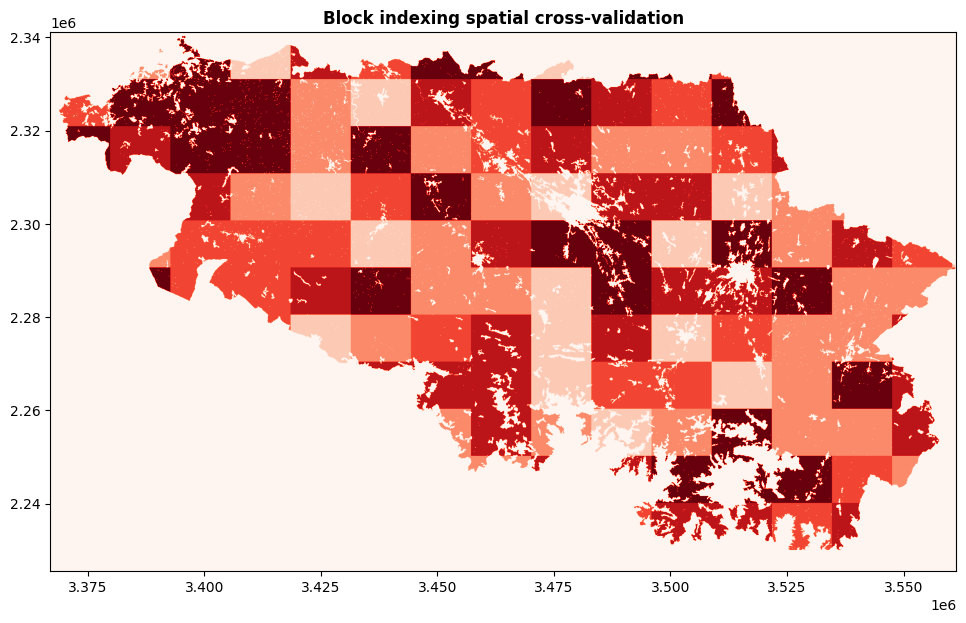

In [61]:
visualize_raster(block_values_filter.values)

We are going to perform spatial k-fold cross-validation i.e the data is divided into k folds, and the model is trained and evaluated on k-1 folds, with one fold left out as the test set. We visualize how the group k-fold would merge our groups with the following.

Split 0
Ratio train :  0.0653292526654972
Ratio test :  0.04012306259062531
Split 1
Ratio train :  0.06948224008853124
Ratio test :  0.021285789596494714
Split 2
Ratio train :  0.05399283750397293
Ratio test :  0.07822735341593522
Split 3
Ratio train :  0.04784855865436292
Ratio test :  0.10921080904095853
Split 4
Ratio train :  0.05939435192427054
Ratio test :  0.05704722071786975


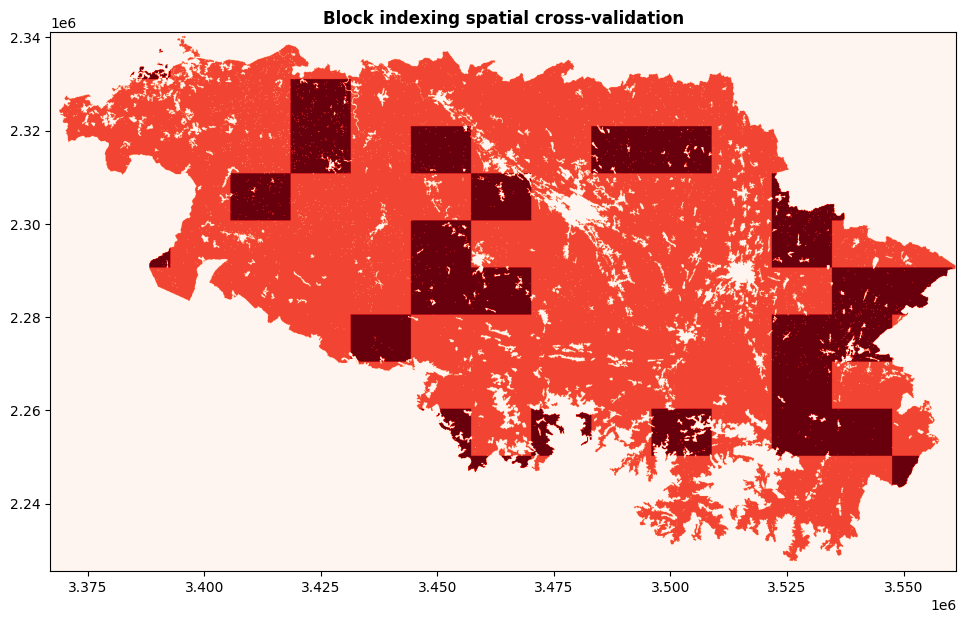

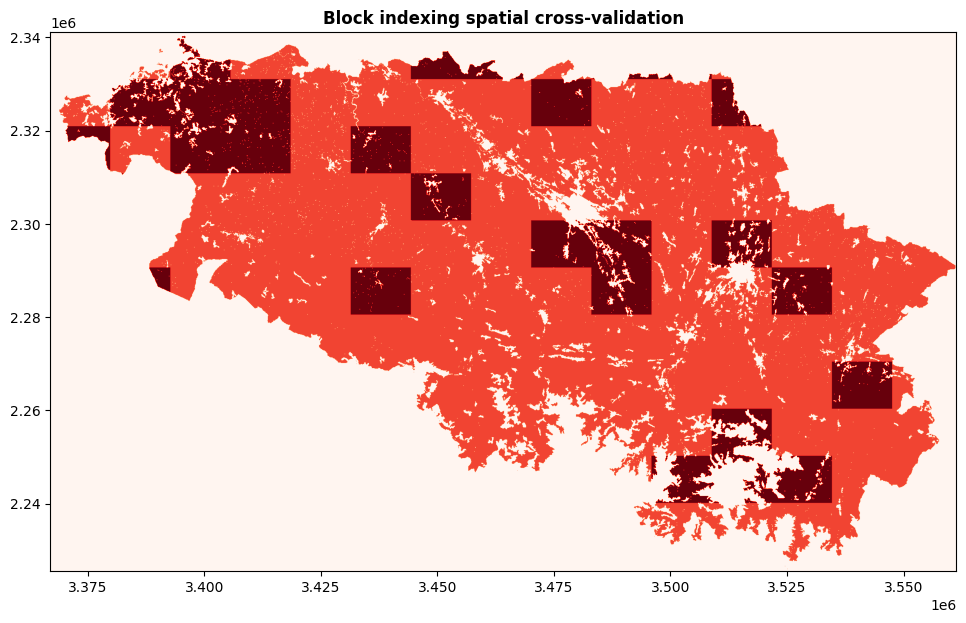

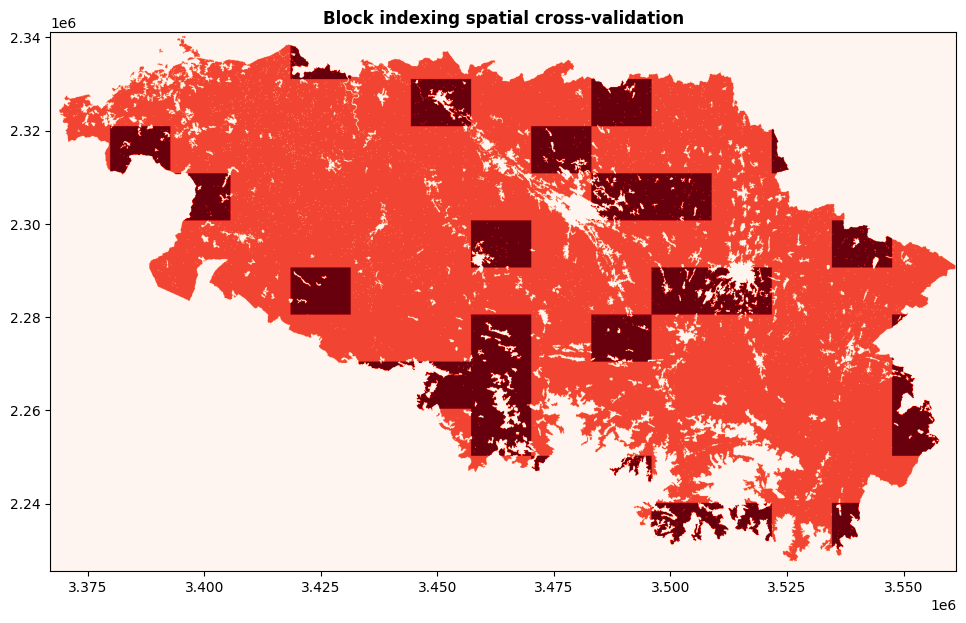

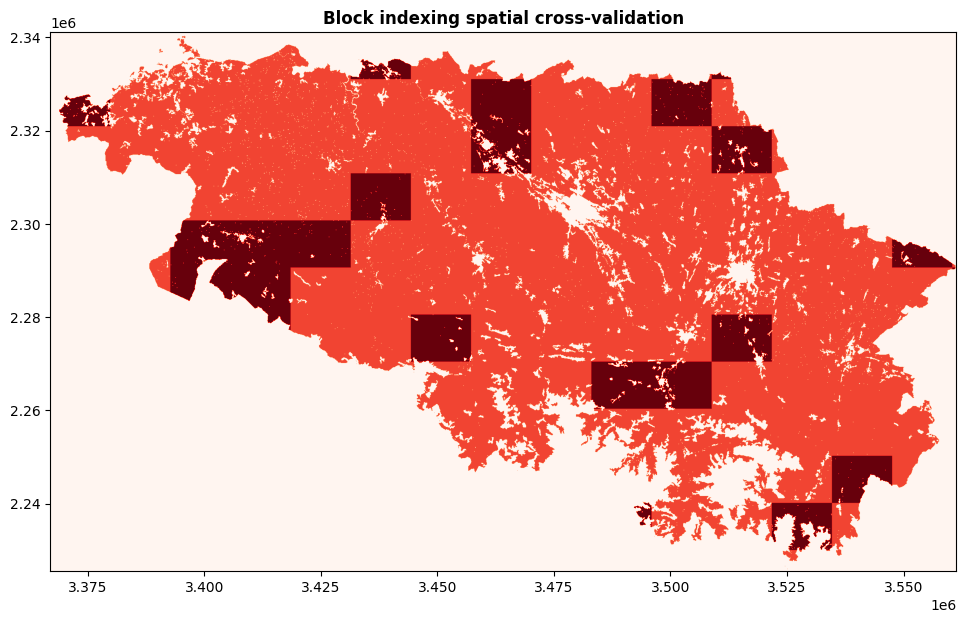

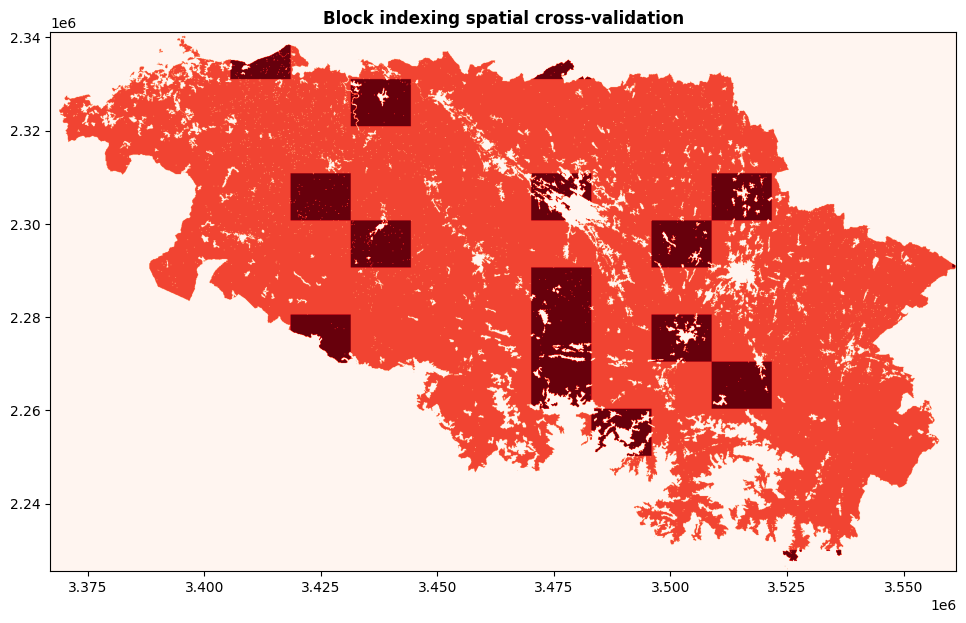

In [62]:
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

gkf_cv = StratifiedGroupKFold(n_splits=5)
feature_norm = ['slope', 'dem', 'emi', 'lst', 'ndvi', 'evi', 'vi', 'qflag', 'ampl', 'minv', 'maxv', 'rslope', 'lslope', 
                'dist_2', 'dist_3', 'dist_4', 'fire_count']
feature_cols = ['protected'] + lc_cols + feature_norm

for split, (ix_train, ix_test) in enumerate(gkf_cv.split(df.loc[:, feature_cols], df.is_fire, groups = df['block'])):
    block_values_filter[df.index] = df['block']
    block_values_filter[df.index[ix_train]] = 3
    block_values_filter[df.index[ix_test]] = 5
    df_split_train = (df.loc[df.index[ix_train]])
    df_split_test = (df.loc[df.index[ix_test]])
    print('Split', split)
    print('Ratio train : ', len(df_split_train[df_split_train.is_fire == 1])/len(df_split_train))
    print('Ratio test : ', len(df_split_test[df_split_test.is_fire == 1])/len(df_split_test))
    visualize_raster(block_values_filter.values)

**Save datasets**

In [66]:
%%time

feature_norm = ['slope', 'dem', 'emi', 'lst', 'ndvi', 'evi', 'vi', 'ampl', 'minv', 'maxv', 'rslope', 'lslope', 
                'dist_2', 'dist_3', 'dist_4', 'fire_count']

# min max normalization
df[feature_norm] = (df[feature_norm] - df[feature_norm].min()) / (df[feature_norm].max() - df[feature_norm].min())
df_test[feature_norm] = (df_test[feature_norm] - df_test[feature_norm].min()) / (df_test[feature_norm].max() - df_test[feature_norm].min())

index = df.index
df_ind = df.reset_index()
feature_cols = ['protected'] + lc_cols + feature_norm
X_train = df_ind.loc[:, feature_cols]
y_train = df_ind.is_fire

X_test = df_test.loc[:, feature_cols]
y_test = df_test.is_fire

CPU times: user 1.11 s, sys: 332 ms, total: 1.44 s
Wall time: 1.44 s


In [69]:
X_train.to_pickle('../generated/data_pkl/X_train.pkl')
X_test.to_pickle('../generated/data_pkl/X_test.pkl')
y_train.to_pickle('../generated/data_pkl/y_train.pkl')
y_test.to_pickle('../generated/data_pkl/y_test.pkl')

df['block'].to_pickle('../generated/data_pkl/block_cv.pkl')
df_data.to_pickle('../generated/data_pkl/df_data.pkl')

**Use datasets**

In [65]:
X_train = read_pickle('../generated/data_pkl/X_train.pkl')
X_test = read_pickle('../generated/data_pkl/X_test.pkl')
y_train = read_pickle('../generated/data_pkl/y_train.pkl')
y_test = read_pickle('../generated/data_pkl/y_test.pkl')

NameError: name 'read_pickle' is not defined

## Models

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import RandomizedSearchCV

**Calibration**  
Probability calibration is the process of adjusting the predicted probabilities output by a machine learning model such that they accurately reflect the true underlying probabilities of the classes. In other words, it involves adjusting the model's predictions so that they are more closely aligned with the actual outcomes of the events being predicted.

There are two main types of probability calibration: Platt scaling and isotonic regression. Platt scaling, also known as sigmoid calibration, involves fitting a sigmoid curve to the predicted probabilities output by the model, in order to adjust them to be more accurate. Isotonic regression involves fitting a step function to the predicted probabilities, such that the probabilities are monotonically increasing.

In [25]:
# model + calibration
# cv = ((train, test) for train, test in StratifiedGroupKFold(n_splits=5).split(X_train, y_train, groups=df['block']))
rf_clf = RandomForestClassifier(max_depth = 3, class_weight = 'balanced', n_estimators = 100)
calibrated_clf = CalibratedClassifierCV(rf_clf, method = 'isotonic', cv = cv)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                             max_depth=3),
                       cv=<generator object <genexpr> at 0x000001F66C912C10>,
                       method='isotonic')

In [26]:
model = calibrated_clf

In [27]:
y_predict = model.predict(X_test)

In [68]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, fbeta_score, confusion_matrix
from sklearn.metrics import classification_report

def make_classification_report(y_test, y_predict, threshold = 0, f=None):
    y_pred = y_predict
    if (threshold != 0):
        y_pred = [1 if (x >= threshold) else 0 for x in y_predict]
    return f"""
    Precision: {precision_score(y_test, y_pred)}\n
    Recall: {recall_score(y_test, y_pred)}\n
    F1-score: {f1_score(y_test, y_pred)}\n
    Accuracy: {accuracy_score(y_test, y_pred)}\n
    Classification Report : \n
    {classification_report(y_test, y_pred, target_names=['Not burnt', 'Burnt'])}\n
    """
    # f1-score is the harmonic mean between precision and recall

In [29]:
make_classification_report(y_test, y_predict)

Precision 0.18325042896511085
Recall 0.7540293823990871
F1-Score 0.29484515958114305
F2-Score 0.464604297578767
Accuracy 0.9527329960567993
Classification Report : 
              precision    recall  f1-score   support

   Not burnt       1.00      0.96      0.98   1055921
       Burnt       0.18      0.75      0.29     14022

    accuracy                           0.95   1069943
   macro avg       0.59      0.85      0.64   1069943
weighted avg       0.99      0.95      0.97   1069943



In [30]:
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay

def plot_metrics(y_test, y_pred_proba, y_predict):
    #define metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)

    f, axs = plt.subplots(1, 2, figsize=(15,5))

    #create ROC curve
    axs[0].plot(fpr, tpr, label="AUC="+str(auc))
    axs[0].plot(lr_precision, lr_recall, label="Precision/Recall")
    axs[0].set_ylabel('True Positive Rate/Precision')
    axs[0].set_xlabel('False Positive Rate/Recall')
    axs[0].legend(loc=4)

    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axs[1], colorbar=False)
    _ = disp.ax_.set_title("Calibrated Random Forest")
    plt.show()
    return fpr, tpr, thresholds

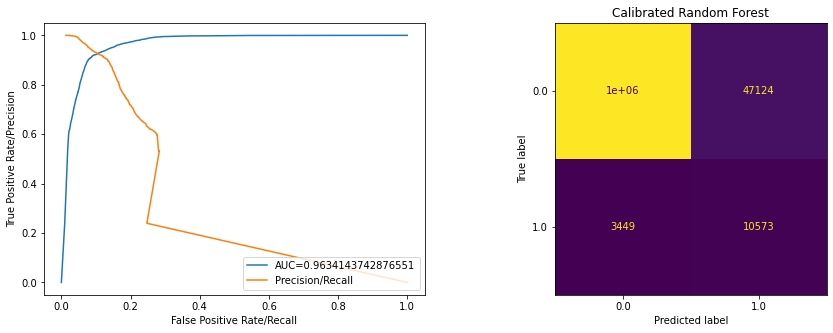

In [31]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = plot_metrics(y_test, y_pred_proba, y_predict)

We find the optimal threshold as the point of the ROC curve closest to the top left-corner (i.e true positive rate equal to 1 and false positive rate equal to 0). Mathematically, we write it as :

In [32]:
# optimal threshold for the classifier 
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

make_classification_report(y_test, y_pred_proba, optimal_threshold)

Threshold value is: 0.2144014466975636
Precision 0.11922777345053967
Recall 0.9169875909285409
F1-Score 0.21101865983949586
F2-Score 0.392174804187102
Accuracy 0.9101353997362477
Classification Report : 
              precision    recall  f1-score   support

   Not burnt       1.00      0.91      0.95   1055921
       Burnt       0.12      0.92      0.21     14022

    accuracy                           0.91   1069943
   macro avg       0.56      0.91      0.58   1069943
weighted avg       0.99      0.91      0.94   1069943



#### Susceptibility map

In [33]:
def create_susceptibility_map(filename, y_pred_proba):
    ds = gdal.Open('data_final/protected/raster_natural_protected.tif')
    band = ds.GetRasterBand(1)
    ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    wkt = ds.GetProjection()


    # Create gtif file
    driver = gdal.GetDriverByName("GTiff")
    output_file = "output/"+filename+".tif"

    y_pred_rescaled = pd.Series(np.zeros(len(df_data)))
    y_pred_rescaled[X_test.index] = y_pred_proba
    array_rf = np.reshape(y_pred_rescaled.values, (1156, 1943))

    dst_ds = driver.Create(output_file,
                           band.XSize,
                           band.YSize,
                           1,
                           gdal.GDT_Float32)

    #writing output raster
    dst_ds.GetRasterBand(1).WriteArray( array_rf )

    #setting nodata value
    dst_ds.GetRasterBand(1).SetNoDataValue(0)

    #setting extension of output raster
    dst_ds.SetGeoTransform(geotransform)

    # setting spatial reference of output raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection( srs.ExportToWkt() )

    #Close output raster dataset
    ds = None
    dst_ds = None

In [34]:
create_susceptibility_map('susceptibility_rf', y_pred_proba)

<AxesSubplot: title={'center': 'Fire Map 2022'}>

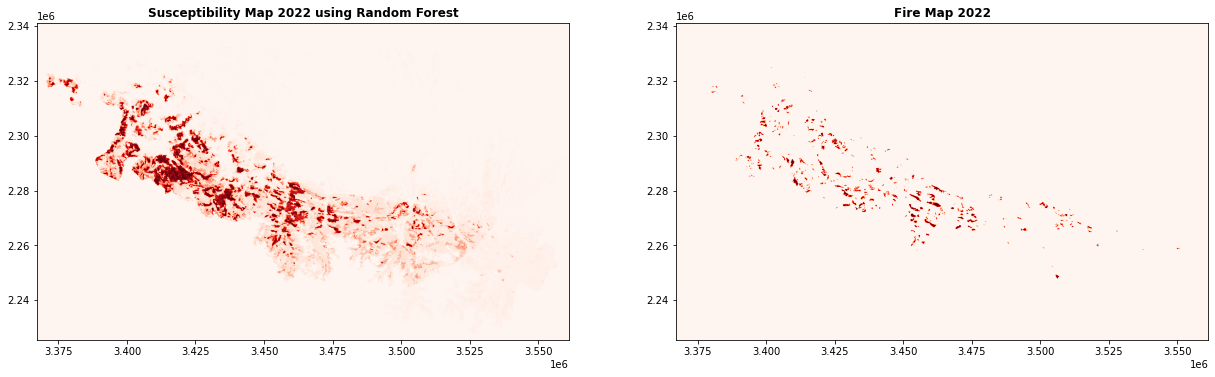

In [35]:
susceptibility_rf = rasterio.open('output/susceptibility_rf.tif')
array_r = susceptibility_rf.read(1).flatten()

fig, axs = plt.subplots(1, 2, figsize=(21,7))
show((susceptibility_rf, 1), ax=axs[0], cmap='Reds', title = 'Susceptibility Map 2022 using Random Forest')
show((fireyear_raster['2022'], 1), cmap='Reds', ax=axs[1], title = 'Fire Map 2022')

#### Explainability

**Pre-calibration RandomForest feature importance** 

In [36]:
# Pre-calibrated model
precalib_rf = model.base_estimator.fit(X_train, y_train)

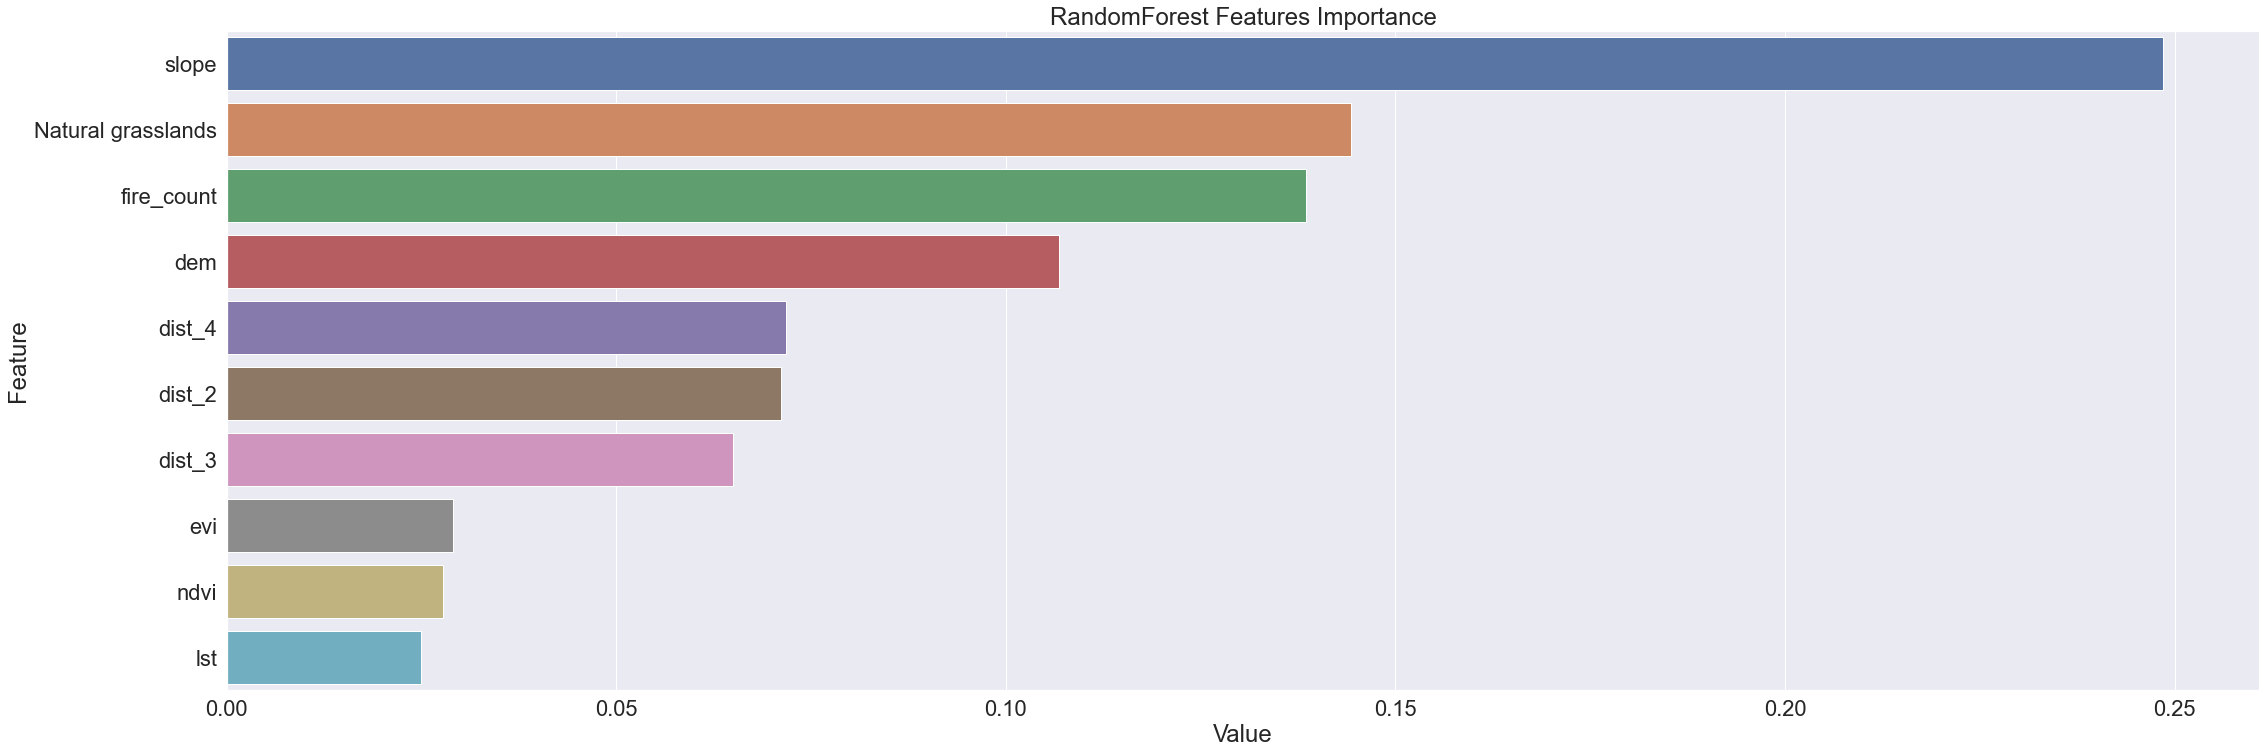

In [37]:
importances = precalib_rf.feature_importances_

feature_imp = pd.DataFrame({'Value': importances, 'Feature': [legend_column[s] if ('lc' in s) else s for s in list(X_train.columns)]})

plt.figure(figsize=(32, 11))
sn.set(font_scale = 2)
sn.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('RandomForest Features Importance')
plt.tight_layout()
plt.savefig('output/rf_importances-01.png')
plt.show()

**SHAP values**

In [38]:
shap.initjs()
# using calibrated classifier base estimator
sample_test = shap.sample(X_test, 100) 
sample_test = sample_test.reset_index().drop(columns = ['index'])
sample_test.columns = [legend_column[s] if ('lc' in s) else s for s in list(sample_test.columns)]

size = len(sample_test)
explainer = shap.TreeExplainer(precalib_rf)
shap_values = explainer.shap_values(sample_test)
shap.force_plot(explainer.expected_value[1], shap_values[1][:size,:], sample_test.iloc[:size,:])

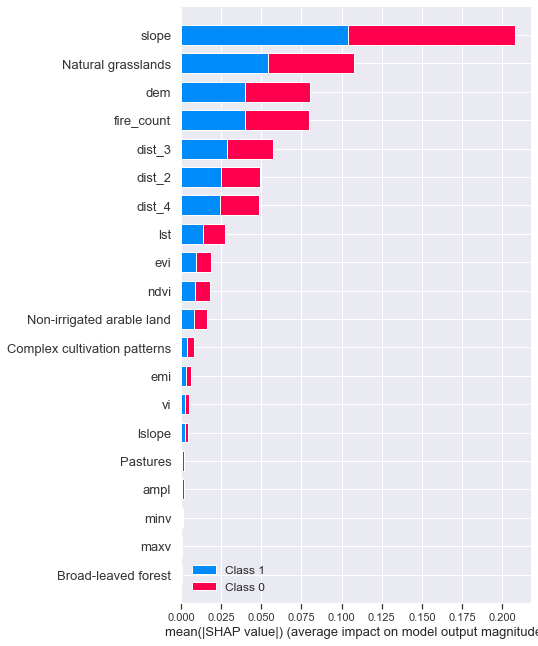

In [39]:
shap.summary_plot(shap_values, sample_test)

### Light GBM

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import RandomizedSearchCV

**Save pickle**

In [40]:
%%time
feature_norm = ['slope', 'dem', 'emi', 'lst', 'ndvi', 'evi', 'vi', 'qflag', 'ampl', 'minv', 'maxv', 'rslope', 'lslope', 
                'dist_2', 'dist_3', 'dist_4', 'fire_count']

# min max normalization
df[feature_norm] = (df[feature_norm] - df[feature_norm].min()) / (df[feature_norm].max() - df[feature_norm].min())
df_test[feature_norm] = (df_test[feature_norm] - df_test[feature_norm].min()) / (df_test[feature_norm].max() - df_test[feature_norm].min())

index = df.index
df_ind = df.reset_index()
feature_cols = ['protected'] + lc_cols + feature_norm

X_train = df_ind.loc[:, feature_cols]
y_train = df_ind.is_fire

X_test = df_test.loc[:, feature_cols]
y_test = df_test.is_fire

Wall time: 3.76 s


In [54]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

**Use pickle**

In [56]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

**Train**

In [41]:
%%time
from sklearn.metrics import log_loss
import lightgbm as lgb

"""# model + calibration 
for train, test in StratifiedGroupKFold(n_splits=5).split(X_train, y_train, groups=df['block']):
    X_train_fold = (X_train.loc[X_train.index[train]])
    y_train_fold = (y_train.loc[y_train.index[train]])
    
    X_test_fold = (X_test.loc[X_test.index[test]])
    y_test_fold = (y_test.loc[y_test.index[test]])
    
    # model training
    rf_clf = lgb.LGBMClassifier(boosting='goss', max_depth=6)
    calibrated_clf = CalibratedClassifierCV(rf_clf, method = 'isotonic')
    calibrated_clf.fit(X_train_fold, y_train_fold)
    
    # evaluation
    y_pred = calibrated_clf.predict(X_test_fold)
    print("LOG LOSS :", log_loss(y_test_fold, y_pred))"""
    
# model training
rf_clf = lgb.LGBMClassifier(boosting='goss', max_depth=20, n_estimators=100)
calibrated_clf = CalibratedClassifierCV(rf_clf, method = 'isotonic')
calibrated_clf.fit(X_train, y_train)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Wall time: 35.1 s


CalibratedClassifierCV(base_estimator=LGBMClassifier(boosting='goss',
                                                     max_depth=20),
                       method='isotonic')

In [42]:
model = calibrated_clf

In [43]:
y_predict = model.predict(X_test)

In [44]:
make_classification_report(y_test, y_predict)

Precision 0.08706508015996728
Recall 0.8803309085722436
F1-Score 0.15845854647916255
F2-Score 0.3119266982366944
Accuracy 0.8774579580407554
Classification Report : 
              precision    recall  f1-score   support

   Not burnt       1.00      0.88      0.93   1055921
       Burnt       0.09      0.88      0.16     14022

    accuracy                           0.88   1069943
   macro avg       0.54      0.88      0.55   1069943
weighted avg       0.99      0.88      0.92   1069943



In [45]:
y_pred_proba = model.predict_proba(X_test)[::,1]

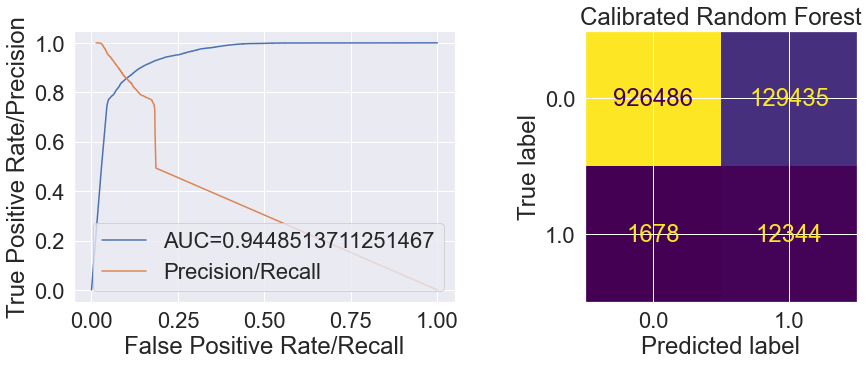

Wall time: 15.6 s


(array([0.        , 0.02860536, 0.02860725, ..., 0.99944503, 0.99972062,
        1.        ]),
 array([0.        , 0.49322493, 0.49322493, ..., 1.        , 1.        ,
        1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99884277e-01, ...,
        4.10677618e-05, 2.18173885e-05, 0.00000000e+00]))

In [46]:
%%time
plot_metrics(y_test, y_pred_proba, y_predict)

In [47]:
create_susceptibility_map('sus_lgbm', y_pred_proba)

<AxesSubplot: title={'center': 'Fire Map 2022'}>

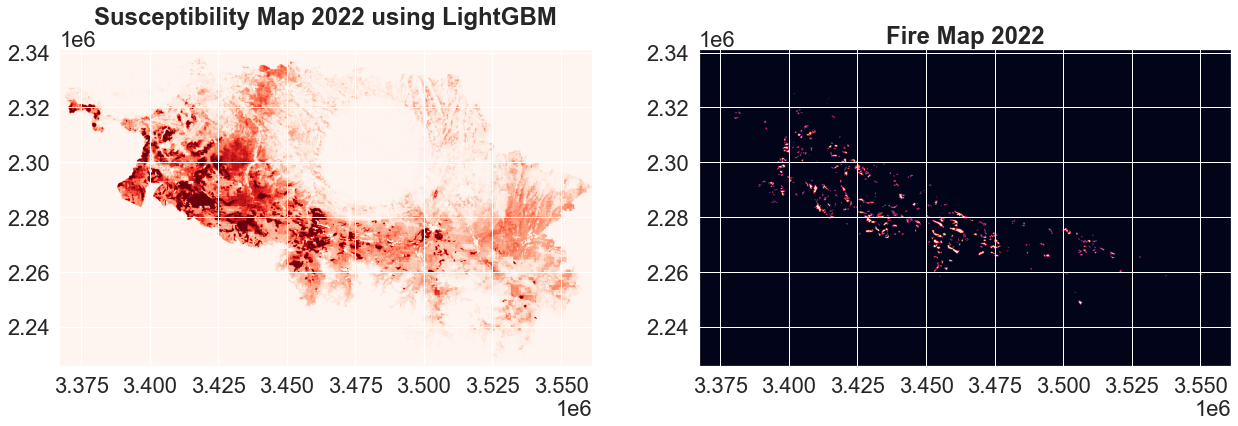

In [48]:
susceptibility_rf = rasterio.open('output/sus_lgbm.tif')
array_r = susceptibility_rf.read(1).flatten()

fig, axs = plt.subplots(1, 2, figsize=(21,7))
show((susceptibility_rf, 1), ax=axs[0], cmap='Reds', title = 'Susceptibility Map 2022 using LightGBM')
show((fireyear_raster['2022'], 1), ax=axs[1], title = 'Fire Map 2022')

#### Explainability
**Pre-calibration LightGBM feature importance** 

In [49]:
# Pre-calibrated model
lgbm_best = model.base_estimator.fit(X_train, y_train)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


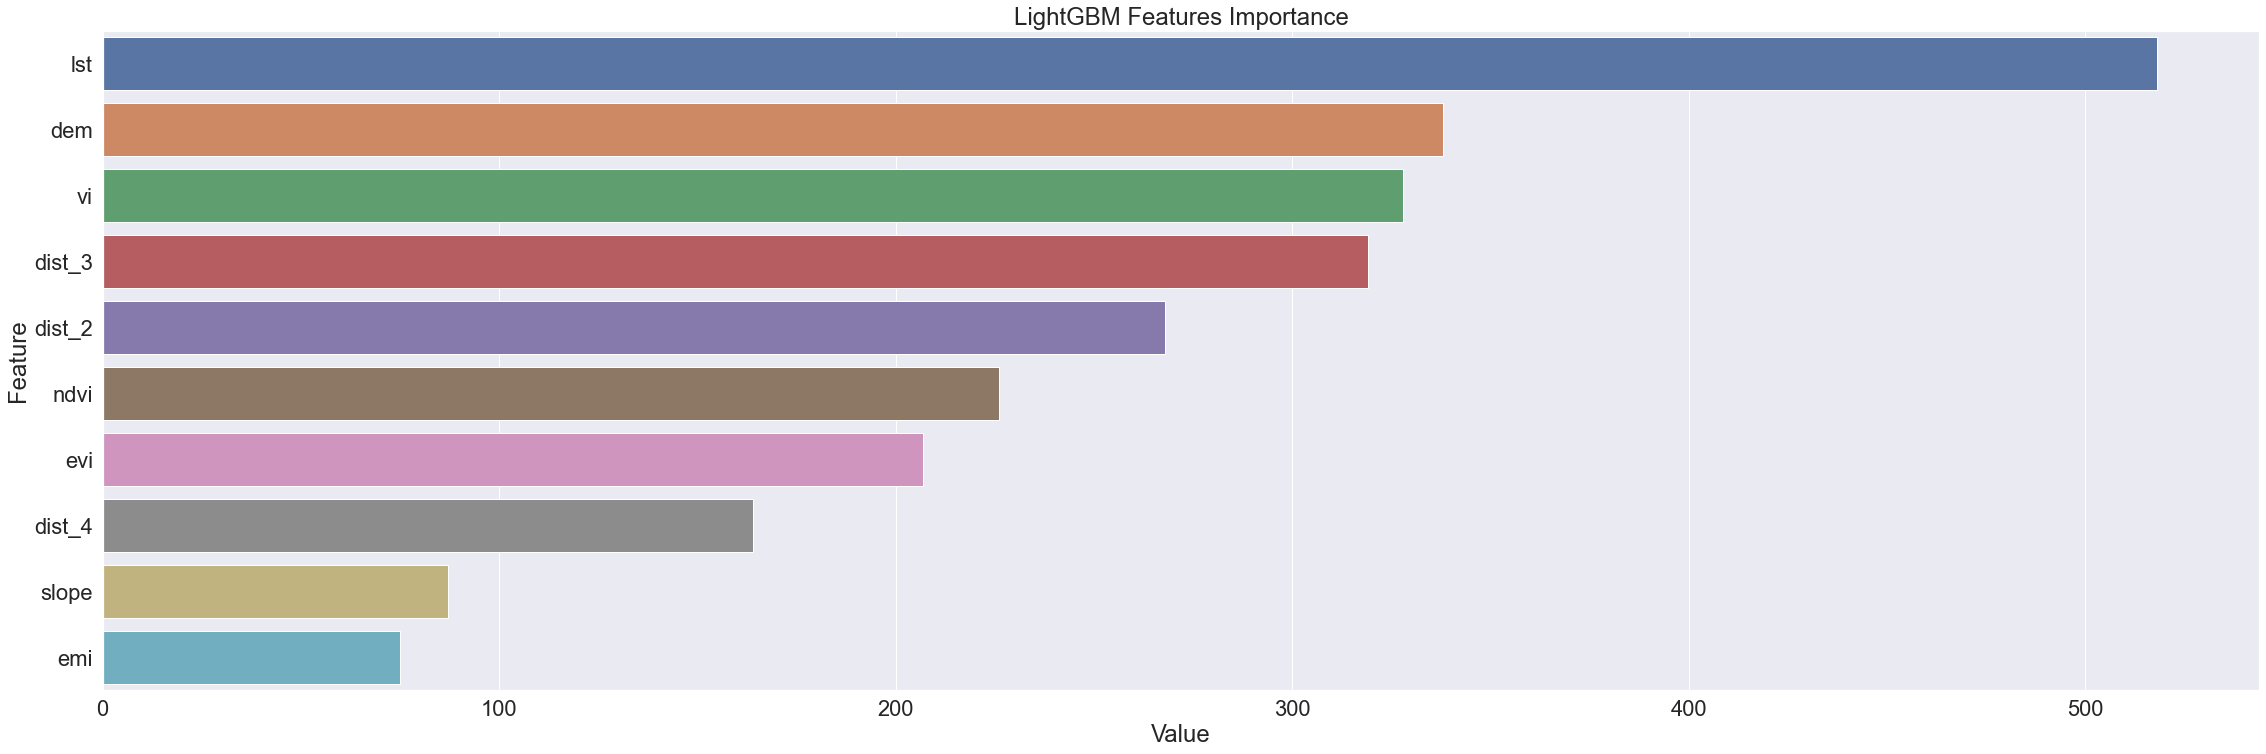

In [50]:
# Pre-calibration model
booster = lgbm_best.booster_
feature_imp = pd.DataFrame({'Value': booster.feature_importance(), 'Feature': [legend_column[s] if ('lc' in s) else s for s in list(X_train.columns)]})

plt.figure(figsize=(32, 11))
sn.set(font_scale = 2)
sn.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.savefig('output/lgbm_importances-01.png')
plt.show()

**Pre-calibration SHAP values**

In [51]:
shap.initjs()
# using calibrated classifier base estimator
sample_test = shap.sample(X_test, 100) 
sample_test = sample_test.reset_index().drop(columns = ['index'])
sample_test.columns = [legend_column[s] if ('lc' in s) else s for s in list(sample_test.columns)]

size = len(sample_test)
explainer = shap.TreeExplainer(lgbm_best)
shap_values = explainer.shap_values(sample_test)
shap.force_plot(explainer.expected_value[1], shap_values[1][:size,:], sample_test.iloc[:size,:])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


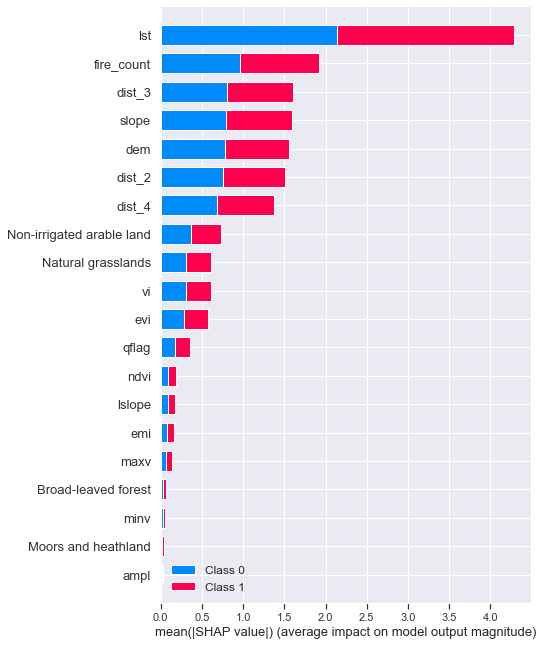

In [53]:
shap.summary_plot(shap_values, sample_test)